<a href="https://colab.research.google.com/github/irwanmaulana42/google-collab/blob/master/Klasifikasi%20Varietas%20Beras%20Basmathi%2C%20IR64%2C%20Pandan%20MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi 3 Varietas Beras**

# Mengambil *Dataset* dari *Firebase*

In [2]:
import os
import requests
from zipfile import ZipFile
from io import BytesIO  # Mengimpor BytesIO

In [ ]:
import shutil

shutil.rmtree('/content/Rice_Image_Dataset')

In [3]:
zip_url = "https://firebasestorage.googleapis.com/v0/b/portofolio-2f6ce.appspot.com/o/rice_datasets_new.zip?alt=media&token=4249937c-8007-4743-a0f2-04cd5d74c0f6"

# Direktori tempat file zip akan diekstrak
extract_dir = "/content/Rice_Image_Dataset"

# Unduh file zip
response = requests.get(zip_url)
zip_data = ZipFile(BytesIO(response.content))

# Ekstrak file zip
zip_data.extractall(extract_dir)

# Tentukan direktori yang berisi dataset
dataset_dir = os.path.join(extract_dir, "rice_datasets")


In [4]:
print(dataset_dir)

/content/Rice_Image_Dataset/rice_datasets


In [5]:
!ls /content/Rice_Image_Dataset/rice_datasets

test  train


## Persiapan

Program ini dibuat untuk membedakan 3 varietas beras yaitu :

1.   Varietas Beras Basmathi
2.   Varietas Beras IR 64
3.   Varietas Beras Pandan

Pada program ini menggunakan metode *Convolutional Neural Network* (CNN) untuk melakukan klasifikasinya.

## Memasukan Fungsi *Library*

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Mengimpor Dataset

In [7]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls /content/Rice_Image_Dataset/rice_datasets

!ls /content/Rice_Image_Dataset/rice_datasets/train
!ls /content/Rice_Image_Dataset/rice_datasets/train/Basmathi
!ls /content/Rice_Image_Dataset/rice_datasets/train/IR64
!ls /content/Rice_Image_Dataset/rice_datasets/train/Pandan

test  train
Basmathi  IR64	Pandan
B100.jpg  B19.jpg  B28.jpg  B37.jpg  B46.jpg  B55.jpg  B64.jpg	B73.jpg  B82.jpg  B91.jpg
B10.jpg   B1.jpg   B29.jpg  B38.jpg  B47.jpg  B56.jpg  B65.jpg	B74.jpg  B83.jpg  B92.jpg
B11.jpg   B20.jpg  B2.jpg   B39.jpg  B48.jpg  B57.jpg  B66.jpg	B75.jpg  B84.jpg  B93.jpg
B12.jpg   B21.jpg  B30.jpg  B3.jpg   B49.jpg  B58.jpg  B67.jpg	B76.jpg  B85.jpg  B94.jpg
B13.jpg   B22.jpg  B31.jpg  B40.jpg  B4.jpg   B59.jpg  B68.jpg	B77.jpg  B86.jpg  B95.jpg
B14.jpg   B23.jpg  B32.jpg  B41.jpg  B50.jpg  B5.jpg   B69.jpg	B78.jpg  B87.jpg  B96.jpg
B15.jpg   B24.jpg  B33.jpg  B42.jpg  B51.jpg  B60.jpg  B6.jpg	B79.jpg  B88.jpg  B97.jpg
B16.jpg   B25.jpg  B34.jpg  B43.jpg  B52.jpg  B61.jpg  B70.jpg	B7.jpg	 B89.jpg  B98.jpg
B17.jpg   B26.jpg  B35.jpg  B44.jpg  B53.jpg  B62.jpg  B71.jpg	B80.jpg  B8.jpg   B99.jpg
B18.jpg   B27.jpg  B36.jpg  B45.jpg  B54.jpg  B63.jpg  B72.jpg	B81.jpg  B90.jpg  B9.jpg
I100.jpg  I19.jpg  I28.jpg  I37.jpg  I46.jpg  I55.jpg  I64.jpg	I73.jpg  I82.jpg

In [8]:
def display_images(image_paths, titles):
    plt.figure(figsize=(10, 10))  # Set ukuran figure sesuai kebutuhan
    for i, (img_path, title) in enumerate(zip(image_paths, titles)):
        img = imread(img_path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')  # Menonaktifkan sumbu
    plt.show()


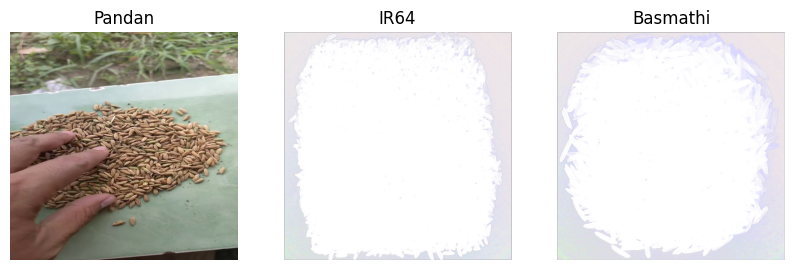

In [9]:
# Definisikan direktori gambar
base_dir = "/content/Rice_Image_Dataset/rice_datasets/train"

# Tentukan nama folder dan gambar
categories = ["Pandan", "IR64", "Basmathi"]
image_files = ["P17.jpg", "I64.jpg", "B10.jpg"]  # Pastikan ini adalah nama gambar yang ada

# Buat daftar path gambar
image_paths = [os.path.join(base_dir, cat, img_file) for cat, img_file in zip(categories, image_files)]

# Menampilkan gambar
display_images(image_paths, categories)

In [10]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('/content/Rice_Image_Dataset/rice_datasets/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Basmathi', 'IR64', 'Pandan']

for i,label in enumerate(labels):
    folder = os.path.join("/content/Rice_Image_Dataset/rice_datasets/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)

        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)


Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset validation (validasi) adalah: (60, 224, 224, 3) (60, 3)
Bentuk array dari dataset test (pengujian) adalah: (45, 224, 224, 4) (45,)


## Menyimpan Label

In [11]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Basmathi': 0, 'IR64': 1, 'Pandan': 2}


In [12]:
!cat labels.txt

Basmathi
IR64
Pandan

# Membuat Model dari Jaringan CNN yang Sudah dipelajari Sebelumnya (*pre-trained convnets*)

In [80]:
IMG_SHAPE = (224, 224, 3)

# name_model = "MOBILE_NET"
# # Model ImageNet

# # Membuat model dasar (base model) dari pre-trained model MobileNet
# base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
#                                               include_top=False,
#                                              weights='imagenet')

# name_model = "RES_NET"
# # Model ResNet50
# # Mengganti model MobileNet dengan ResNet50
# base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
#                                             include_top=False,
#                                             weights='imagenet')

name_model = "INCEPTION_V3"
# Model InceptionV3
# Mengganti model MobileNet atau ResNet dengan InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


87924736/87910968 [==============================] - 0s 0us/step


## *Feature Extraction*

Menggunakan model *pre-trained* untuk ekstraksi fitur (*feature extraction*) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat contoh model *pre-trained* dan menambahkan classifier yang sepenuhnya terhubung di atas. Model *pre-trained* adalah "beku" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusional mengekstraksi semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih classifier yang menentukan kelas gambar mengingat set fitur yang diekstraksi.

1. Ekstraksi Fitur Warna

In [70]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def extract_color_features(image):
    # Pastikan gambar adalah format BGR
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Gambar harus memiliki 3 channel (warna BGR)")

    # Menghitung histogram warna
    hist_b = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_r = cv2.calcHist([image], [2], None, [256], [0, 256])

    # Menormalisasi histogram
    hist_b = cv2.normalize(hist_b, hist_b).flatten()
    hist_g = cv2.normalize(hist_g, hist_g).flatten()
    hist_r = cv2.normalize(hist_r, hist_r).flatten()

    # Menggabungkan histogram
    color_features = np.hstack([hist_b, hist_g, hist_r])

    return color_features


# Ekstraksi Fitur Bentuk
def extract_shape_features(image):
    # Mengkonversi gambar ke grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Menggunakan deteksi tepi Canny
    edges = cv2.Canny(gray, 100, 200)

    # Menggunakan deteksi kontur
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Menghitung fitur kontur
    shape_features = [len(contours)]  # Jumlah kontur sebagai contoh

    return shape_features

# Ekstraksi Fitur Tekstur
def extract_texture_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Mendapatkan GLCM
    glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)

    # Menghitung fitur dari GLCM
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')

    texture_features = [contrast.mean(), dissimilarity.mean(), homogeneity.mean(), energy.mean(), correlation.mean()]

    return texture_features

# Ekstraksi Fitur Tekstur
def extract_features(image):
    color_features = extract_color_features(image)
    shape_features = extract_shape_features(image)
    texture_features = extract_texture_features(image)

    # Menggabungkan semua fitur
    all_features = np.concatenate([color_features, shape_features, texture_features])

    return all_features

Menampilkan Fitrue Ekstraksi

In [73]:
def convert_to_rgb_extraction(image):
    if len(image.shape) == 2:  # Gambar grayscale
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[2] == 1:  # Gambar dengan 1 channel (grayscale)
        image = np.concatenate([image] * 3, axis=-1)
    elif image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Skala nilai ke [0, 255] dan ubah tipe data
    return image


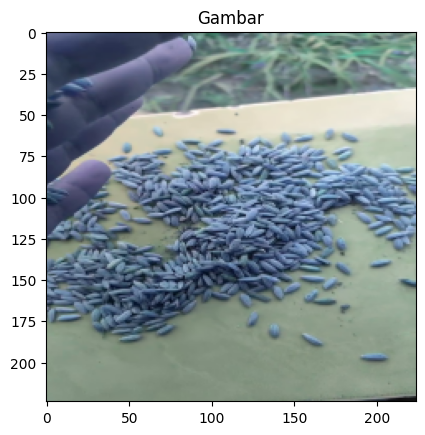

In [79]:
import cv2
import matplotlib.pyplot as plt

# Memilih gambar dari data
image = convert_to_rgb_extraction(X_test[44])  # Misalnya memilih gambar pertama dari X_test

# Menampilkan gambar untuk memastikan
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Gambar")
plt.show()


In [81]:
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_1[0][0]']               
 alization)                     )                                                      

# Mengelompokkan Klasifikasi Tiga Jenis Beras dengan *Deep learning* (*Convolutional Neural Network*)

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [15]:
!pip install tensorflow

In [82]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split


## Mempersiapkan Data Masukkan Pengujian

In [83]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

## Pembuatan Model (Menambah Model)

In [84]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 conv2d_95 (Conv2D)          (None, 3, 3, 32)          589856    
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 22,392,739
Trainable params: 589,955
Non-trainable params: 21,802,784
_________________________________________________________________


## Pelatihan

In [85]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping untuk menghentikan pelatihan lebih awal jika tidak ada perbaikan
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint untuk menyimpan model dengan bobot terbaik
model_checkpoint = ModelCheckpoint("Klasifikasi_Beras_Tumpukan"+ name_model + ".h5", monitor='val_loss', save_best_only=True)

# Fit model dengan callbacks
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
2/2 [==============================] - 51s 23s/step - loss: 2.9598 - acc: 0.4333 - val_loss: 3.8645 - val_acc: 0.6667
Epoch 2/10
2/2 [==============================] - 42s 25s/step - loss: 2.2203 - acc: 0.6667 - val_loss: 0.3447 - val_acc: 0.8000
Epoch 3/10
2/2 [==============================] - 36s 21s/step - loss: 0.3623 - acc: 0.8500 - val_loss: 0.4045 - val_acc: 0.7500
Epoch 4/10
2/2 [==============================] - 40s 25s/step - loss: 0.2019 - acc: 0.9500 - val_loss: 0.1349 - val_acc: 0.9667
Epoch 5/10
2/2 [==============================] - 38s 23s/step - loss: 0.1619 - acc: 0.9375 - val_loss: 0.0785 - val_acc: 0.9833
Epoch 6/10
2/2 [==============================] - 35s 19s/step - loss: 0.0632 - acc: 0.9917 - val_loss: 0.1681 - val_acc: 0.9167
Epoch 7/10
2/2 [==============================] - 37s 22s/step - loss: 0.0604 - acc: 0.9833 - val_loss: 0.0861 - val_acc: 0.9667
Epoch 8/10
2/2 [==============================] - 36s 22s/step - loss: 0.0239 - acc: 1.0000 - val

## Menggambarkan Hasil Pelatihan

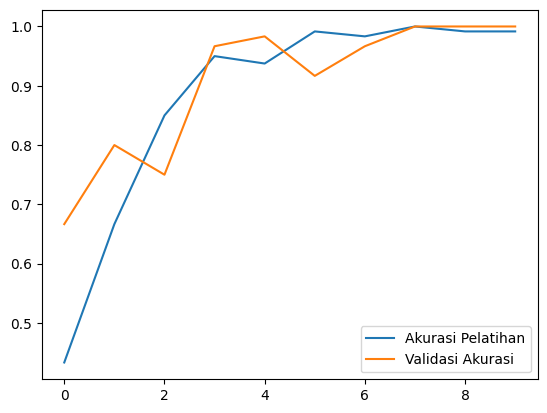

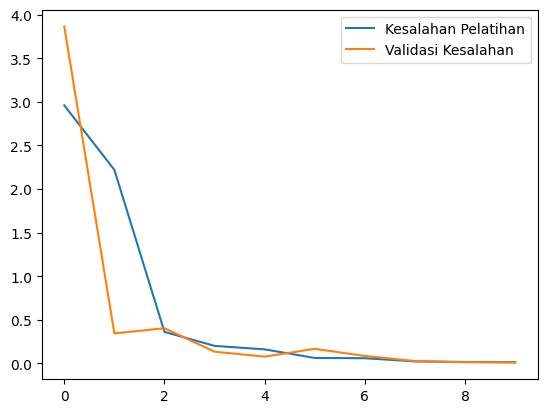

In [86]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [87]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


## Menggunakan Model

In [88]:
print(train_generator)

In [89]:
#Prediksi Label Validasi dengan Pelatihan
n = 44
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [1. 0. 0.]
Prediksinya adalah [1.00e+00 3.01e-04 1.36e-05]


Hasil tersebut merupakan hasil prediksi dari training dari 3 jenis data pelatihan yaitu jenis beras Basmathi, IR 64, dan Pandan. Menggunakan inputan gambar dengan piksel 224 x 224, 1 filter dengan fungsi aktivasi relu, dan 1 layer output dengan fungsi aktivasi softmax

## Evaluasi

In [90]:
import numpy as np

def convert_to_rgb(image):
    if image.dtype == 'float64':
        image = (image * 255).astype('uint8')  # Normalisasi jika diperlukan
    if image.shape[-1] == 4:
        image = image[:, :, :3]  # Ambil hanya saluran RGB
    return image

# Mengonversi array numpy menjadi gambar RGB
X_test3_rgb = np.array([convert_to_rgb(img) for img in X_test3])

# Memeriksa bentuk data setelah konversi
print(X_test3_rgb.shape)  # Harus menjadi (jumlah_gambar, tinggi, lebar, 3)


(45, 224, 224, 3)


In [91]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x= X_test3_rgb, y = y_test3))

['loss', 'acc']
2/2 [==============================] - 6s 2s/step - loss: 65.1693 - acc: 0.3333
[65.16934967041016, 0.3333333432674408]


In [92]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test3_rgb)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


## Prediksi Gambar Individual

In [93]:
import numpy as np

# Fungsi konversi yang telah diperbarui
def convert_to_rgb(image):
    if image.dtype == 'float64':
        image = (image * 255).astype('uint8')  # Normalisasi jika diperlukan
    if image.shape[-1] == 4:
        image = image[:, :, :3]  # Ambil hanya saluran RGB
    return image

# Mengonversi array numpy menjadi gambar RGB
X_test_rgb = np.array([convert_to_rgb(img) for img in X_test])
print(X_test_rgb.shape)  # Harus menjadi (jumlah_gambar, tinggi, lebar, 3)

(45, 224, 224, 3)


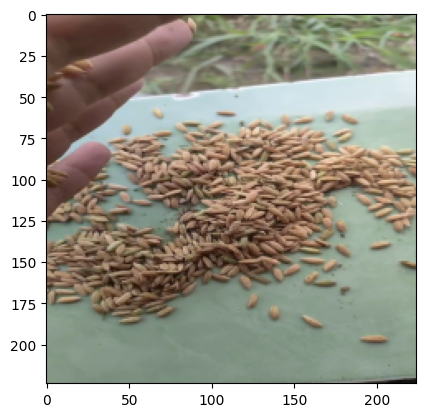

Label yang benar adalah: 2 : Pandan
Nilai yang diprediksi adalah: [1. 0. 0.]
Label yang diprediksi adalah: 0 : Basmathi
Prediksi salah


In [94]:
n = 44 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test_rgb[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test_rgb[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

## *Confusion Matrix*

Normalized confusion matrix
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Label Prediksi', ylabel='Label Benar'>

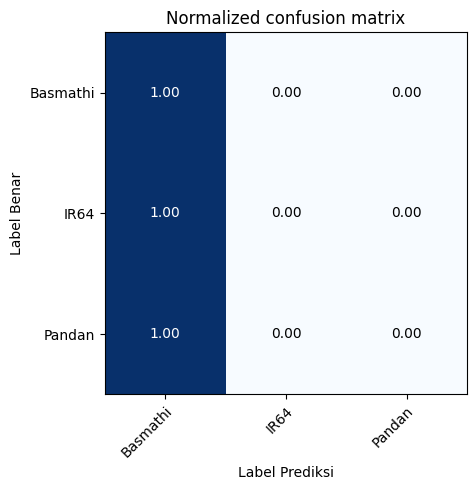

In [96]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

# Menyimpan dan Konversi ke ".tflite"

Menyimpan model menggunakan tf.saved_model.save dan kemudian mengonversi model tersimpan ke format yang kompatibel tf lite.

In [97]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open("Klasifikasi_3_Varietas_Beras_"+name_model+".tflite", 'wb') as f:
  f.write(tflite_model)

Perbandingan algoritma MobileNet, RES NET, dan

**1. MobileNet**
* Akurasi Pelatihan: Sangat tinggi, mencapai 100% pada epoch ke-8 hingga ke-10.
* Akurasi Validasi: Juga sangat tinggi, mencapai 100% pada epoch ke-8 hingga ke-10.
* Loss Pelatihan: Menurun drastis dan mencapai nilai sangat rendah (sekitar 0.01).
* Loss Validasi: Menurun juga dan mencapai nilai sangat rendah (sekitar 0.01).
* Confusion Matrix: [[0. 0. 1.], [0. 0. 1.], [0. 0. 1.]] menunjukkan bahwa model mungkin mengalami masalah dengan data yang tidak seimbang atau prediksi yang sangat terdistorsi.

**2. ResNet50**
* Akurasi Pelatihan: Meningkat seiring dengan epoch, tetapi masih relatif rendah pada akhir pelatihan (sekitar 54%).
* Akurasi Validasi: Lebih rendah dibandingkan dengan MobileNet dan InceptionV3, mencapai puncaknya pada 43% pada epoch ke-10.
* Loss Pelatihan: Berkurang, tetapi masih relatif tinggi pada akhir pelatihan (sekitar 1.09).
* Loss Validasi: Berkurang tetapi tetap tinggi (sekitar 1.10).
* Confusion Matrix: [[0. 0.4 0.6], [0. 0. 1.], [0. 0. 1.]] menunjukkan bahwa model tidak efektif dalam memprediksi beberapa kelas dan mungkin mengalami masalah dengan data yang tidak seimbang atau ketidakcocokan model dengan data.

**3. InceptionV3**
* Akurasi Pelatihan: Sangat tinggi, mencapai 100% pada epoch ke-8 hingga ke-10.
* Akurasi Validasi: Juga sangat tinggi, mencapai 100% pada epoch ke-8 hingga ke-10.
* Loss Pelatihan: Menurun dengan cepat dan mencapai nilai sangat rendah (sekitar 0.01).
* Loss Validasi: Menurun juga dan mencapai nilai sangat rendah (sekitar 0.01).
* Confusion Matrix: [[1. 0. 0.], [1. 0. 0.], [1. 0. 0.]] menunjukkan bahwa model memprediksi satu kelas dengan sangat baik, tetapi mungkin juga mengalami masalah dengan ketidakseimbangan data.

**Kesimpulan**
* InceptionV3 dan MobileNet menunjukkan kinerja yang sangat baik dengan akurasi tinggi dan loss rendah pada epoch terakhir. Mereka tampaknya lebih baik dalam mempelajari data dibandingkan dengan ResNet50.
* ResNet50 menunjukkan kinerja yang lebih rendah baik dalam akurasi pelatihan maupun validasi. Mungkin ada beberapa masalah dengan model ini dalam hal penyesuaian atau kompleksitas data.
* Confusion Matrix pada MobileNet dan InceptionV3 menunjukkan bahwa mungkin ada masalah dengan data atau prediksi yang terdistorsi, karena semua prediksi dikelompokkan ke satu kelas. Ini bisa menunjukkan masalah dengan data atau mungkin overfitting.

Untuk hasil yang optimal, Anda bisa mencoba teknik berikut:

* Pemeriksaan Data: Pastikan bahwa data seimbang dan berkualitas baik.
* Pengaturan Hiperparameter: Sesuaikan hiperparameter model untuk mendapatkan hasil yang lebih baik.
* Augmentasi Data: Gunakan augmentasi data untuk meningkatkan variasi dalam data pelatihan dan membantu model generalisasi lebih baik.